### Stress Computation of Viscoelasticity

The Kirchoff stress is given by:

$$\mathbf{\tau} = p\mathbf{1} + \mathbb{P}:(\bar{\mathbf{\tau}^e} + \bar{\mathbf{\tau}^v})$$
  
where the pressure $p$ is computed using the incompressibility assumption and boundary condition.  
The equilibrium ($\bar{\mathbf{\tau}}^e$) and non-equilibrium parts ($\bar{\mathbf{\tau}}^v$) of $\bar{\mathbf{\tau}}$ are functions of the unimodular part of the left Cauchy Green Tensor ($\bar{\mathbf{b}}$) and the elastic left Cauchy Green Tensor ($\mathbf{b}_e$) respectively:
$$\bar{\mathbf{\tau}}^e = \bar{\mathbf{\tau}}^e(\bar{\mathbf{b}})$$
$$\bar{\mathbf{\tau}}^v = \bar{\mathbf{\tau}}^v(\mathbf{b}_e)$$


The elastic left Cauchy Green Tensor serves as the strain-based internal variable. The rate of $\mathbf{b}_e$ is governed by the equation:
$$\dot{\mathbf{b}_e} = [-2\dot{\gamma}\mathbf{N}] \text{  } \mathbf{b}_e^{tr}$$


For each model below, we will provide expressions for $\bar{\mathbf{\tau}}^e$, $\bar{\mathbf{\tau}}^v$ and $\dot{\gamma}$.

### Generating synthetic data

In [1]:
import sys
import os

# Get the python script's directory to import functions
current_dir = os.getcwd()
grandparent_dir = os.path.abspath(os.path.join(current_dir, '../../'))
if grandparent_dir not in sys.path:
    sys.path.append(grandparent_dir)


from synthetic_data import *
from optimize import optimize, evaluate

We generate uniaxial cyclic data using the Bergstrom-Boyce model.

$$\mathbf{\bar{\tau}}^e = \frac{\mu}{3} \frac{\mathcal{L}^{-1}(\lambda_r)}{\lambda_r} \; \mathbf{\bar{b}}$$
$$\mathbf{\bar{\tau}}^v = \frac{\mu_v}{3} \frac{\mathcal{L}^{-1}(\lambda^e_r)}{\lambda^e_r} \; \mathbf{b_e}$$
$$\dot{\gamma} = \dot{\gamma}_0[\lambda^i_{chain} - 1]^c\left( \frac{\tau_v}{\hat{\tau}} \right)^m$$

The function used for the stress update of this model can be found in `mat.py` named `ubbi_su`

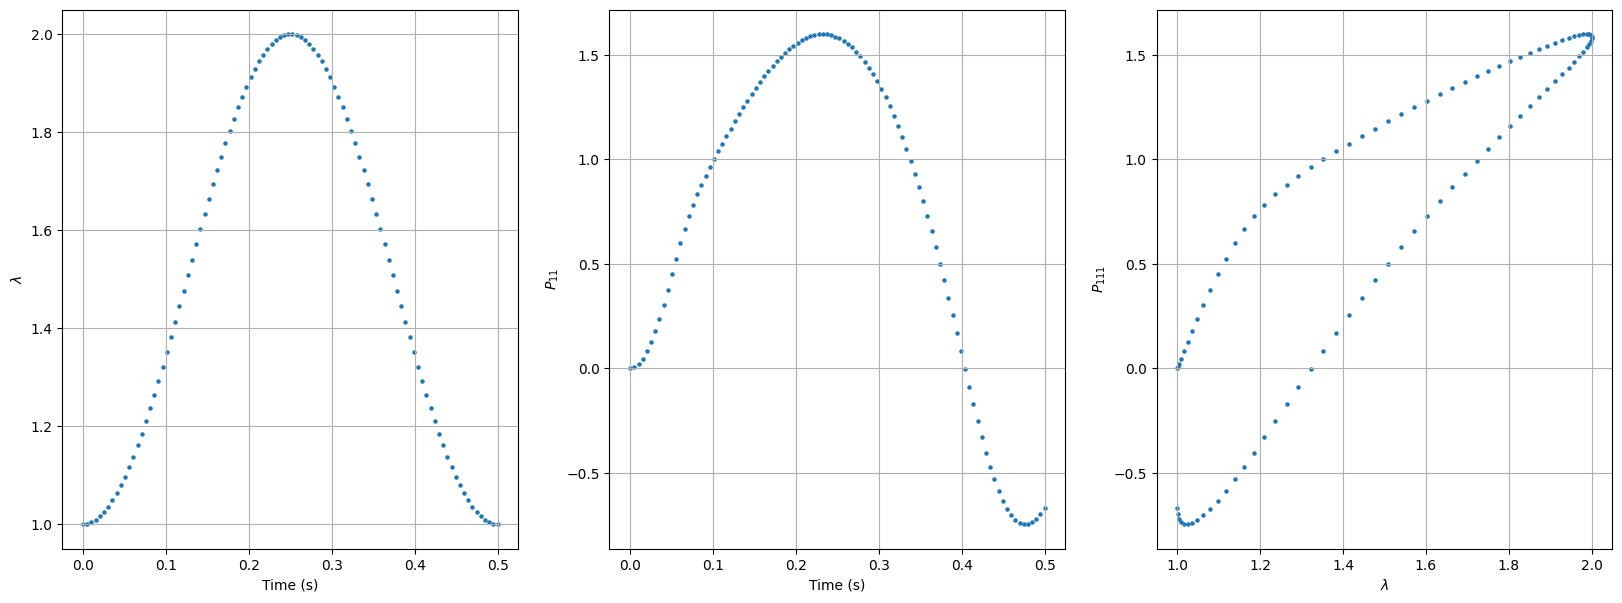

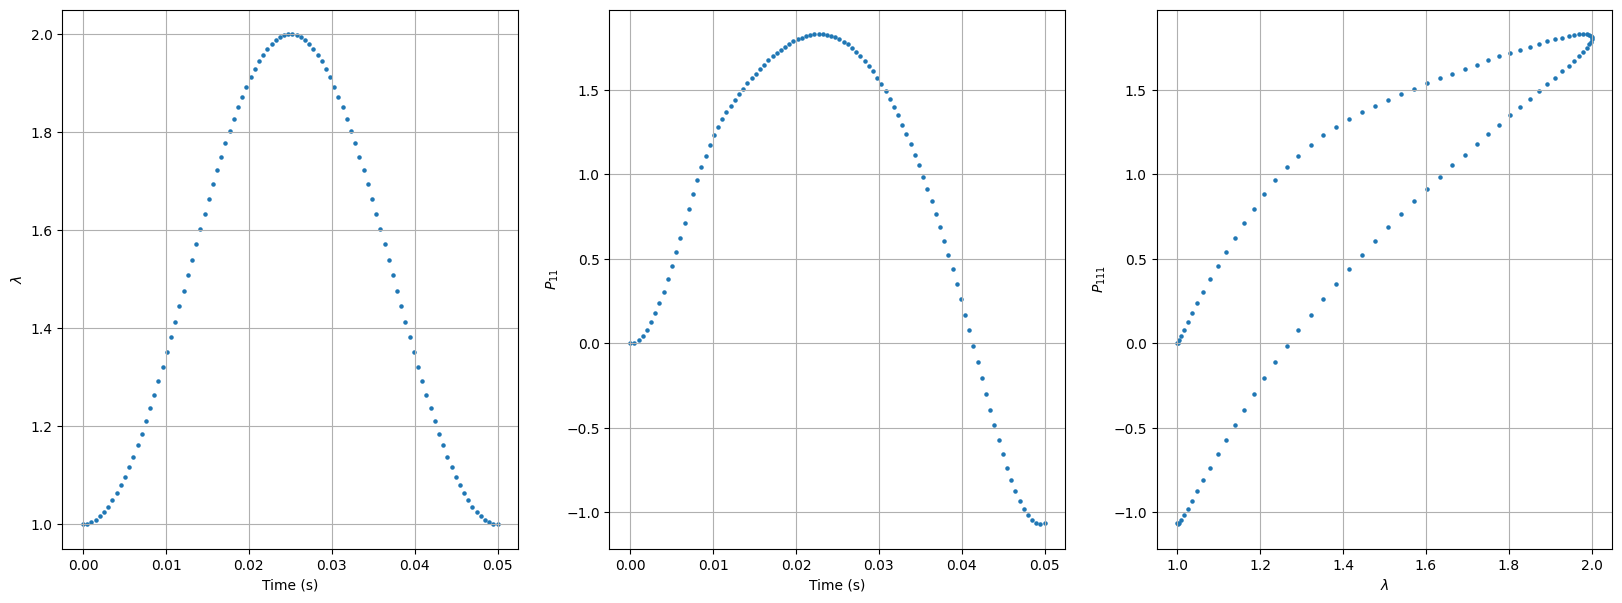

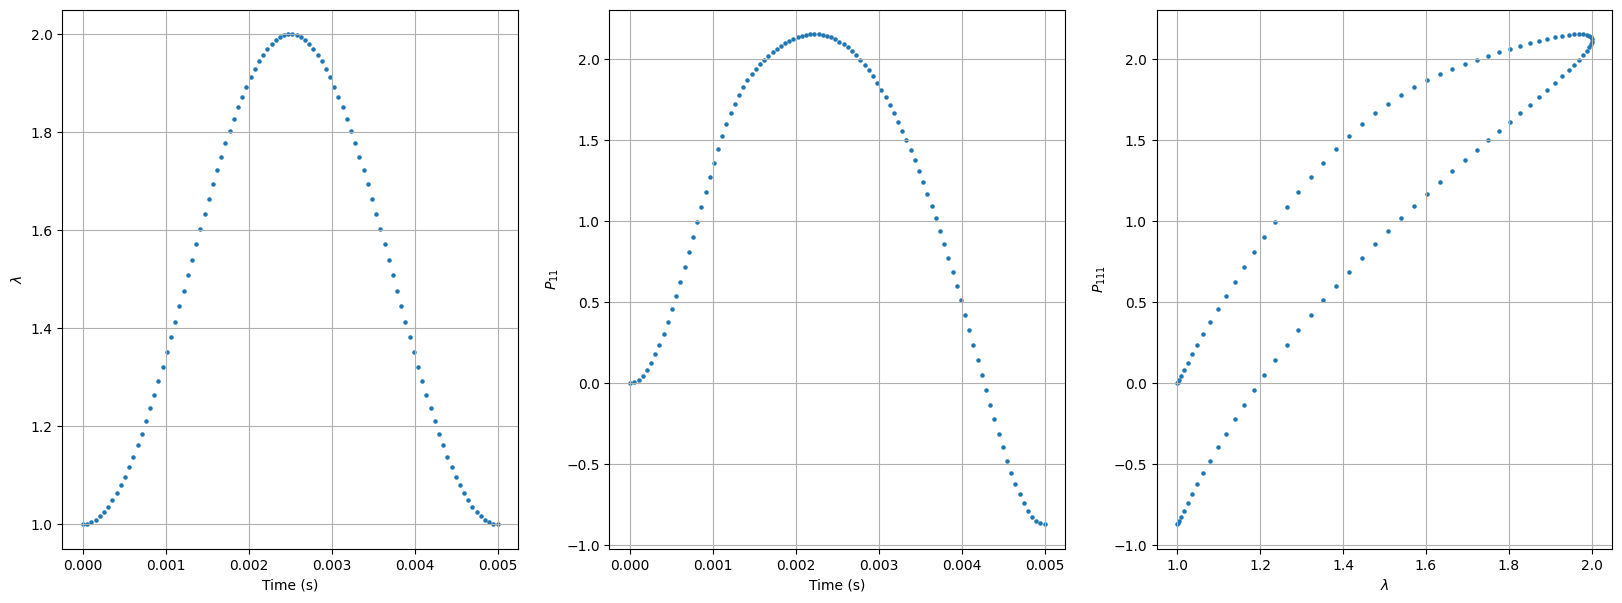

In [2]:
# Identifier to use a Bergstrom-Boyce model for uniaxial
# data with incompressibility assumption (ubbi)
mat = "ubbi"

# Material Parameters (MPa)
mu = 0.6
mu_v = 0.96
N = 8
N_v = 8
gamma0_taum = 7
c = -1
m = 4
params = [mu, mu_v, N, N_v, gamma0_taum, c, m]

# Generate cylic data (time, true_strain, true_stress)
# for three different frequencies
mdata = []
freqs = [2, 20, 200]
for freq in freqs:
    t, stretch = cyclic_loading(max_val=2, min_val=1, start=1, freq=freq,
                                cycles = 1, dt = 0.01/freq,
                                plot=False)
    strain = np.log(stretch)
    t, strain, stress = generate_mdata(t, strain, params, mat, plot=False, noise=0)
    mdata.append((t, strain, stress))

    # Plot nominal stress vs stretch
    stretch = np.exp(strain)
    P11 = stress/stretch
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 3, 1)
    plt.scatter(t, stretch, s = 5)
    plt.xlabel(r'Time (s)')
    plt.ylabel(r'$\lambda$')
    plt.grid()
    plt.subplot(1, 3, 2)
    plt.scatter(t, P11, s = 5)
    plt.xlabel(r'Time (s)')
    plt.ylabel(r'$P_{11}$')
    plt.grid()
    plt.subplot(1, 3, 3)
    plt.scatter(stretch, P11, s = 5)
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$P_{111}$')
    plt.grid()

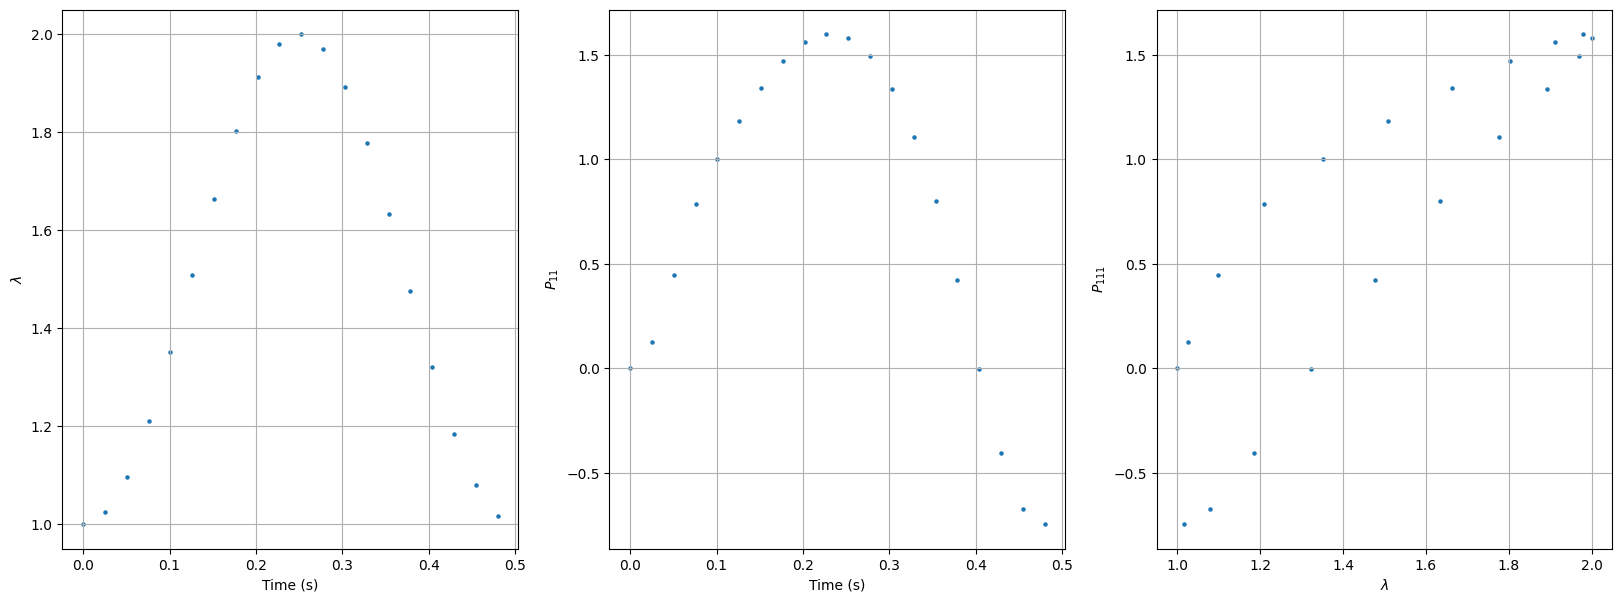

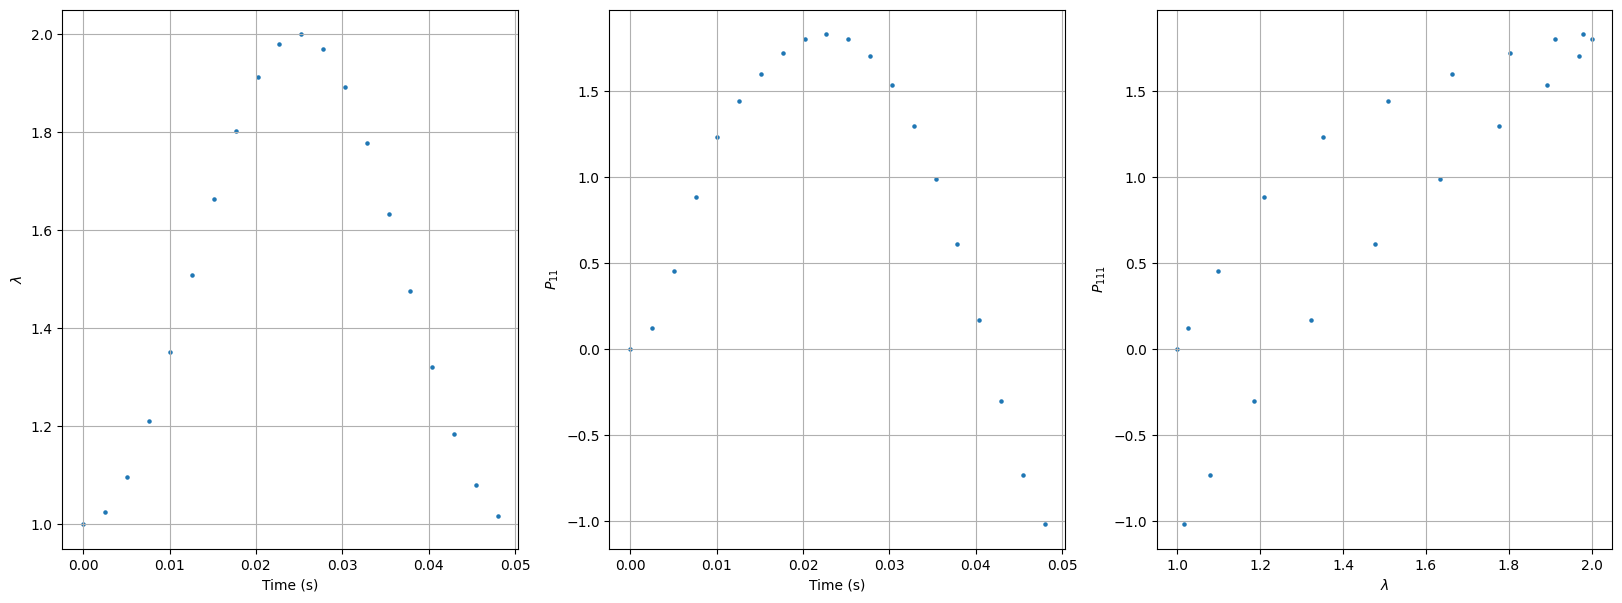

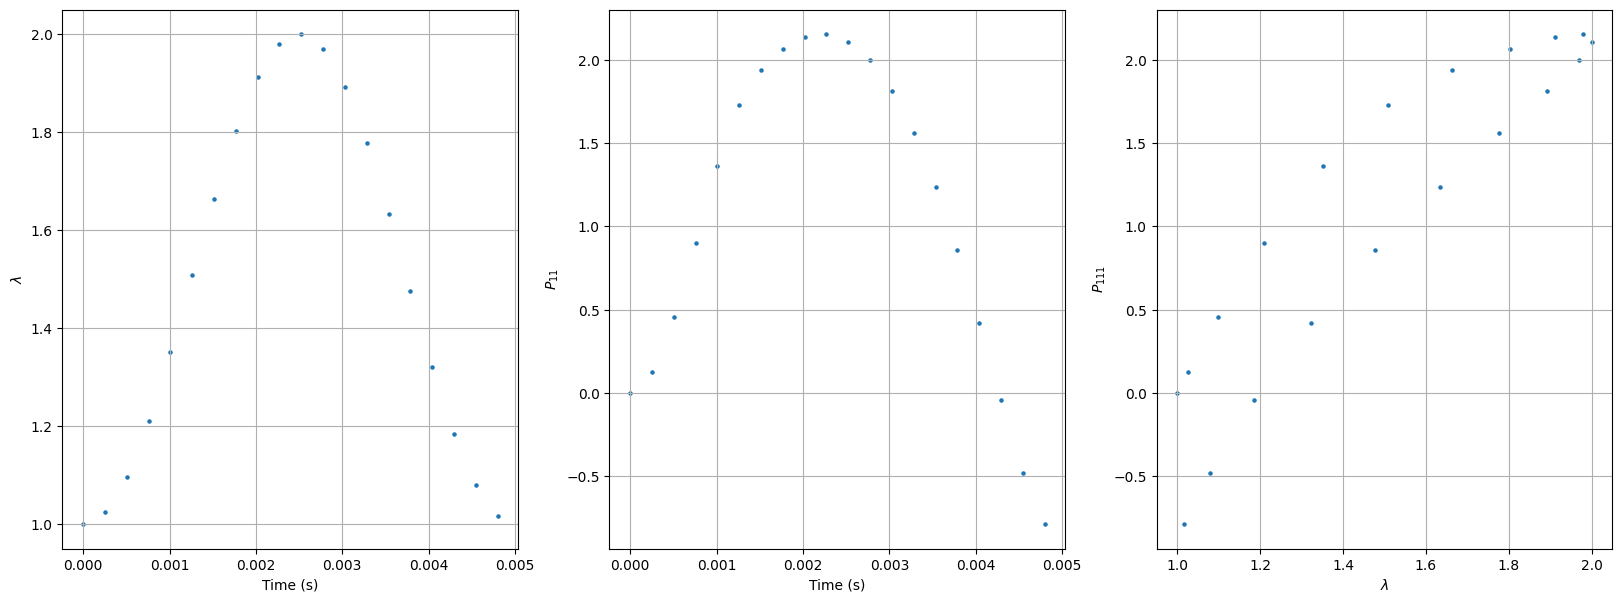

In [3]:
# Reduce the number of points
# The algo can run with much sparser data because 
# we use Backward Euler (unconditionally stable)
n = 5 # Every nth point
mdata_sparse = []
for i, (t, true_strain, true_stress) in enumerate(mdata):
    t = t[::n]
    true_strain = true_strain[::n]
    true_stress = true_stress[::n]
    mdata_sparse.append((t, true_strain, true_stress))

    # Plot nominal stress vs stretch
    stretch = np.exp(true_strain)
    P11 = true_stress/stretch
    plt.figure(figsize=(20, 7))
    plt.subplot(1, 3, 1)
    plt.scatter(t, stretch, s = 5)
    plt.xlabel(r'Time (s)')
    plt.ylabel(r'$\lambda$')
    plt.grid()
    plt.subplot(1, 3, 2)
    plt.scatter(t, P11, s = 5)
    plt.xlabel(r'Time (s)')
    plt.ylabel(r'$P_{11}$')
    plt.grid()
    plt.subplot(1, 3, 3)
    plt.scatter(stretch, P11, s = 5)
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$P_{111}$')
    plt.grid()

### Training the model

The model we use here is formulated using a mooney-rivlin type free energy for both the equilibrium and non-equilibrium parts. We can use an arbitrary number of branches for the non-equilibrium overstresses, here we use 10 branches.  
If you wish to change the number of branches, you can do it in `mat.py` by changing the num_branches in both `umri_su` and `umri_du`.  
The expression for the required stresses are:

$$\mathbf{\bar{\tau}}^e = 2(C_1 + I_1 C_2)\text{  }\mathbf{\bar{b}} - 2 C_2\text{  }\mathbf{\bar{b}}^2$$
$$(\mathbf{\bar{\tau}}^v)_i = 2\big((C_{1v})_i + (I^e_{1})_i (C_{2v})_i\big)\text{  }(\mathbf{b_e})_i - 2 (C_{2v})_i\text{  }(\mathbf{b_e})_i^2 \\ \text{for $i$ = 1 to 10}$$

For the evolution of the internal variable of each branch, we use a simple polynomial equation. We use terms upto the power of 10 for this experiment

$$\dot{\gamma} = \sum^{10}_{j=1} a_j \left( \frac{\tau_v}{\hat{\tau}} \right)^j$$  

In [4]:
# Train and Test split

# Train on the fastest and slowest experiment
mdata_train = [mdata_sparse[0], mdata_sparse[2]]

In [5]:
# Identifier for the model we use
mat = 'umri'

# Initialization of parameters
num_branches = 10
power_terms = 10
c1 = np.random.uniform(0.01, 0.1)
c1_v = [np.random.uniform(0.01, 0.1) for i in range(num_branches)]
c2 = np.random.uniform(0.01, 0.1)
c2_v = [np.random.uniform(0.01, 0.1) for i in range(num_branches)]
tauhinv = [np.random.uniform(0.1, 1) for i in range(num_branches)]
aj = [np.random.uniform(0.1, 1) for i in range(num_branches*power_terms)]
params_init = [c1] + c1_v + [c2] + c2_v + tauhinv + aj

# The names of the parameters for better readibility when outputting the results
params_names = \
    ['c1'] + [f'c1v{i}' for i in range(1, 1 + num_branches)] + \
    ['c2'] + [f'c2v{i}' for i in range(1, 1 + num_branches)] + \
    [f'tauhinv{i}' for i in range(1, 1 + num_branches)] + \
    [f'a{i}_{j}' for i in range(1, 1 + num_branches) for j in range(1, power_terms + 1)]

# Use this to fix any of the parameters (A list or a single values)
# fix_param = \
#     [False] + [False for i in range(1, 1 + num_branches)] + \
#     [False] + [False for i in range(1, 1 + num_branches)] + \
#     [False for i in range(1, 1 + num_branches)] + \
#     [False for i in range(1, 1 + num_branches) for j in range(1, power_terms + 1)]
fix_param = False

# The parameter used for the L1 regularization
lm = 1e-1
lambda_1 = \
    [0] + [lm for i in range(1, 1 + num_branches)] + \
    [0] + [lm for i in range(1, 1 + num_branches)] + \
    [lm for i in range(1, 1 + num_branches)] + \
    [lm for i in range(1, 1 + num_branches) for j in range(1, power_terms + 1)]
# All learnable params except the one in the equilibrium branch are regularized/sparsified

In case you don't wish to go through the training, you can directly go to the evaluate part and use the saved learned parameters

In [6]:
# Run the optimization
params_out, params_hist, loss_hist = \
optimize(mdata_train, params_init, params_names, mat, max_iter=3000, print_after=1000, plot_after = 3000, tol=10e-4,
         alpha=1e-1, b1=0.9, b2=0.999, e=1e-8, lambda_1 = lambda_1,
         non_neg = True,
         fix_param = fix_param,
         get_lowest=True)

Initial values
c1  : 0.07114528434752479
c1v1  : 0.09353430780364598
c1v2  : 0.09763368476716695
c1v3  : 0.08778289305663119
c1v4  : 0.07300098302128608
c1v5  : 0.09104595484670897
c1v6  : 0.08329018275526008
c1v7  : 0.021833542198969977
c1v8  : 0.09660716692941805
c1v9  : 0.04120081862593005
c1v10  : 0.033279141931814055
c2  : 0.02310772619443001
c2v1  : 0.06116886129297389
c2v2  : 0.08701141943046102
c2v3  : 0.018332054764619788
c2v4  : 0.09099355513258349
c2v5  : 0.07120198874238853
c2v6  : 0.07049238726451855
c2v7  : 0.025812472470962487
c2v8  : 0.07522171611491073
c2v9  : 0.06386286920896543
c2v10  : 0.05317617019737366
tauhinv1  : 0.5960242669304227
tauhinv2  : 0.6257284044797345
tauhinv3  : 0.28739120150881886
tauhinv4  : 0.3727367612089252
tauhinv5  : 0.2000037803006341
tauhinv6  : 0.27377628715037117
tauhinv7  : 0.9505597164568866
tauhinv8  : 0.6498956613927225
tauhinv9  : 0.3222365021505889
tauhinv10  : 0.7208792041678013
a1_1  : 0.3757248402342739
a1_2  : 0.31427803683398725


 --------------------------------- 



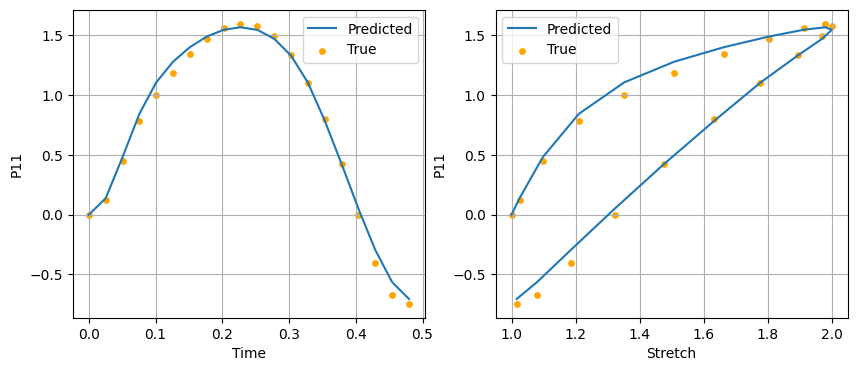

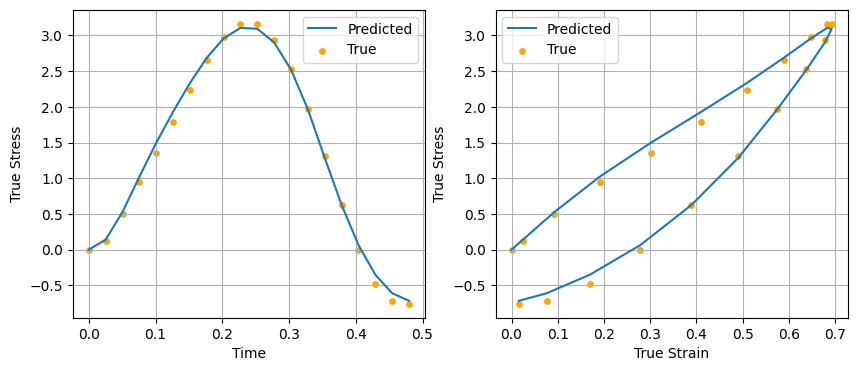


 --------------------------------- 



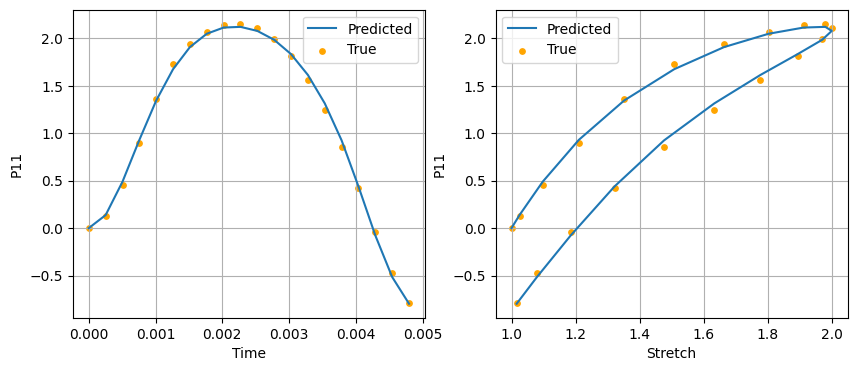

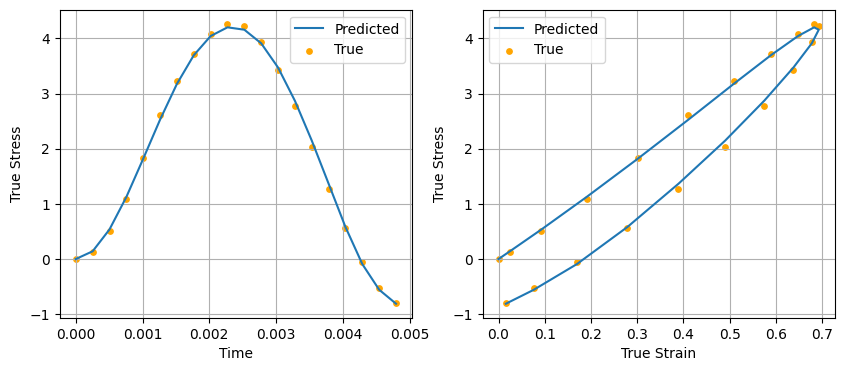

In [7]:
# Fit on the training data
L, pred = evaluate(mdata_train, params_out, mat, plot=True)

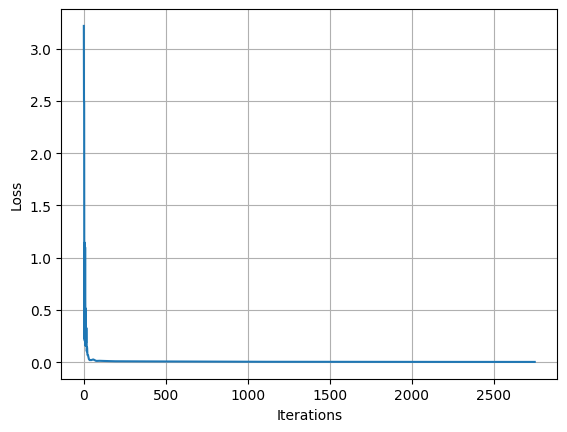

In [8]:
# Plot the loss hist
plt.plot(loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()

In [9]:
import pickle

with open('results.pkl', 'wb') as file:
    pickle.dump([params_out, params_hist, loss_hist], file)

### Evaluate the results

In [15]:
import pickle

with open('results.pkl', 'rb') as file:
    params_out, params_hist, loss_hist = pickle.load(file)
params_out = params_hist[-1]

In [16]:
print('###--NON ZERO PARAMETERS--###')

for j in range(len(params_out)):
    if params_out[j] > 1e-7:
        print(params_names[j], " :", params_out[j])

###--NON ZERO PARAMETERS--###
c1  : 0.35220525184788415
c1v2  : 0.23567507050975764
c2v2  : 0.11538483011115287
c2v7  : 0.24462377499077045
tauhinv2  : 1.8013289941200188
tauhinv7  : 5.371820457703791
a2_3  : 2.321436248798702
a2_4  : 14.062092510780406
a2_5  : 20.39838967560826
a7_5  : 14.523539095436867
a7_6  : 27.39929635266499
a7_7  : 18.84208110947354
a7_8  : 2.007095835852139



 --------------------------------- 



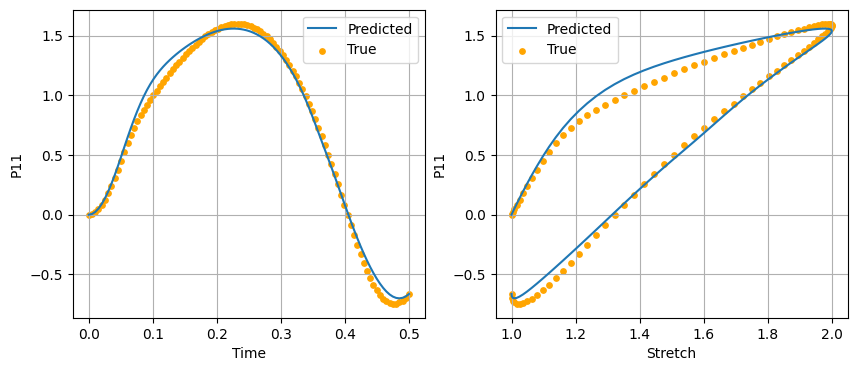

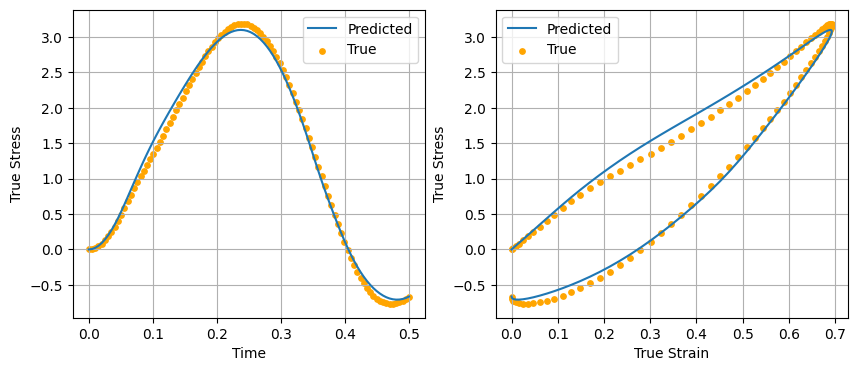


 --------------------------------- 



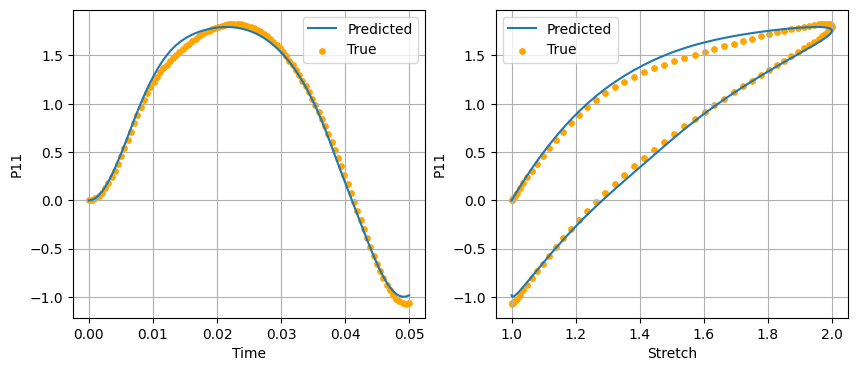

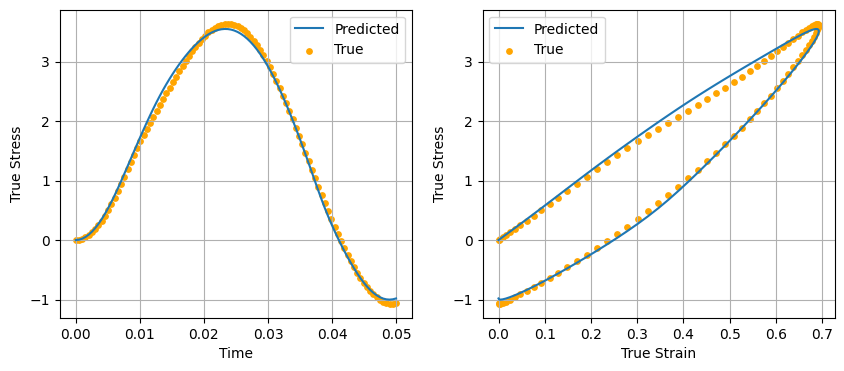


 --------------------------------- 



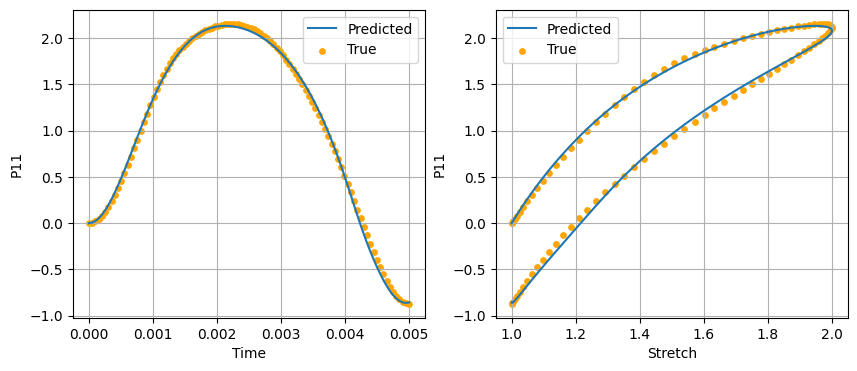

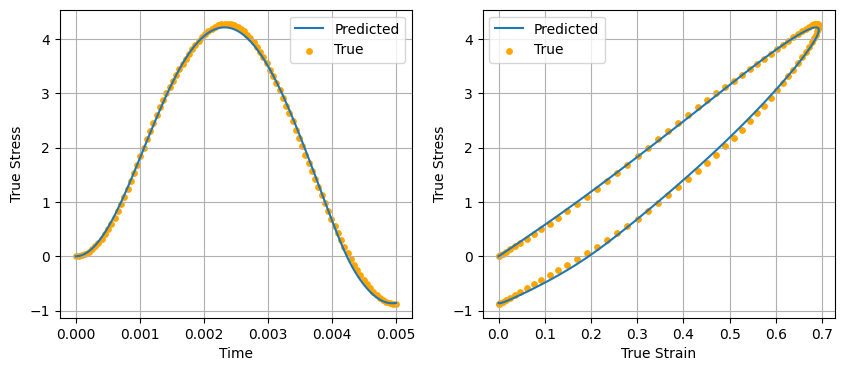

In [17]:
L, pred = evaluate(mdata, params_out, mat, plot=True)